In [12]:
#Libraries
import gspread
import json
import re
import string
import os
#import nltk #if running for the first time you will need to download the nltk data with nltk.download()

#Aliased libraries
import pandas as pd
import matplotlib.pyplot as plt

#Modules
#from nltk.corpus import stopwords
from oauth2client.service_account import ServiceAccountCredentials
from math import pi
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 \
  import Features, EntitiesOptions, KeywordsOptions, SentimentOptions, EmotionOptions

#Watson credentials
with open('Authorization/watson_client_secret.json') as json_key:
    watson_key = json.load(json_key)
    
apikey = watson_key['apikey'] 
watson_url = watson_key['url']

natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-10-29',
    url=watson_url,
    iam_apikey=apikey
)

#authorize google sheets
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name('Authorization/google_client_secret.json', scope)

gc = gspread.authorize(credentials)

wks = gc.open("watsonForms (Responses)").sheet1

In [13]:
# Extract values and put into dataframe
data = wks.get_all_records()

#make dataframes
df = pd.DataFrame(data, columns=data[0].keys())

#Rename the question columns to something easier
df.columns.values[1] = 'q1_text'
df.columns.values[2] = 'q2_text'
df.columns.values[3] = 'q3_text'

#show the data frame
df

,Timestamp,q1_text,q2_text,q3_text
0,21/11/2018 11:33:21,Good - like them. Good - like them. Good - lik...,A waste of good pizza. A waste of good pizza...,They rock ;) They rock ;) They rock ;) They ro...
1,21/11/2018 11:35:25,"they're ok, but sometimes they can be annoying...",love. Who doesn't love a combination of sweet ...,"they make good pets, great pets actually. They..."
2,21/11/2018 11:36:18,I love dogs!!!! French Bulldogs in particular!...,I'm not opposed to pineapple on pizza. But it ...,"Ummm, I don't really have any feelings about r..."
3,21/11/2018 11:36:43,"Extremely positively. Dogs are the best, they ...",It shouldn't be on a pizza. It's a fruit. It's...,Were way more fun when you were a kid. You pla...
4,21/11/2018 11:37:04,I love dogs. I have a daschund. I believe what...,"I like pineapple on pizza, always liked Hawaii...","I have no opinion on rocks. It's a debris, the..."
5,21/11/2018 11:38:02,"I love most dogs. Like people, some are jerks,...","Pizza is pizza and, although I may not always ...",Rocks are pretty cool. They're the foundation ...
6,21/11/2018 11:38:31,They're great. They can provide support and he...,I support it and prefer pizza that has pineapp...,I feel like they are a natural resource but al...
7,21/11/2018 11:40:37,Dogs are cute and adorable. Golden Retriever i...,Delicious. Putting fruits on pizzas is always ...,Some rocks are beautiful because of their uniq...
8,21/11/2018 11:51:45,they're the best. they're the best. they're th...,"it's ok, depends on the mood. it's ok, depends...",they rock. they rock. they rock. they rock. th...
9,21/11/2018 11:52:22,I love them because they provide comfort on th...,I love pineapple on pizza because it is someth...,I feel nothing about rocks but understand that...


In [14]:
#watson analysis of text columns
def analysis(textcol, name):
    name= str(name)+'_'
    for item in textcol:
        #create lists to store response data
        
        outputData = pd.DataFrame() #creates a new dataframe that's empty
        try:
            response = natural_language_understanding.analyze(
              text=item,
              features=Features(
                sentiment=SentimentOptions(),
                emotion=EmotionOptions(),
              ))
            response = response.result
            outputData[name+'usage_units'] = pd.Series(response["usage"]["text_units"])
            outputData[name+'feats_used'] = pd.Series(response["usage"]["features"])
            outputData[name+'senti'] = pd.Series(response["sentiment"]["document"]["score"])
            outputData[name+'senti_label'] = pd.Series(response["sentiment"]["document"]["label"])
            outputData[name+'lang'] = pd.Series(response["language"])
            outputData[name+'sad'] = pd.Series(response["emotion"]["document"]["emotion"]["sadness"])
            outputData[name+'joy'] = pd.Series(response["emotion"]["document"]["emotion"]["joy"])
            outputData[name+'fear'] = pd.Series(response["emotion"]["document"]["emotion"]["fear"])
            outputData[name+'disgust'] = pd.Series(response["emotion"]["document"]["emotion"]["disgust"])
            outputData[name+'anger'] = pd.Series(response["emotion"]["document"]["emotion"]["anger"])
        except KeyError:
            outputData[name+'usage_units'] = pd.Series(response["usage"]["text_units"])
            outputData[name+'feats_used'] = pd.Series(response["usage"]["features"])
            outputData[name+'senti'] = pd.Series(response["sentiment"]["document"]["score"])
            outputData[name+'senti_label'] = pd.Series(response["sentiment"]["document"]["label"])
            outputData[name+'lang'] = pd.Series("Null")
            outputData[name+'sad'] = pd.Series("Null")
            outputData[name+'joy'] = pd.Series("Null")
            outputData[name+'fear'] = pd.Series("Null")
            outputData[name+'disgust'] = pd.Series("Null")
            outputData[name+'anger'] = pd.Series("Null")
        except:
            outputData[name+'usage_units'] = pd.Series("Null")
            outputData[name+'feats_used'] = pd.Series("Null")
            outputData[name+'senti'] = pd.Series("Null")
            outputData[name+'senti_label'] = pd.Series("Null")
            outputData[name+'lang'] = pd.Series("Null")
            outputData[name+'sad'] = pd.Series("Null")
            outputData[name+'joy'] = pd.Series("Null")
            outputData[name+'fear'] = pd.Series("Null")
            outputData[name+'disgust'] = pd.Series("Null")
            outputData[name+'anger'] = pd.Series("Null")
        
        if not os.path.isfile('Data/'+name+'watson_Analysis.csv'):
            outputData.to_csv('Data/'+name+'watson_Analysis.csv', header='column_names')
        else: # else it exists so append without writing the header
            outputData.to_csv('Data/'+name+'watson_Analysis.csv', mode='a', header=False)

In [17]:
#run the analysis
analysis(df['q1_text'],'q1')
analysis(df['q2_text'],'q2')
analysis(df['q3_text'],'q3')

In [19]:
#Load Data
df1 = pd.read_csv('Data/q1_watson_Analysis.csv', index_col=0).reset_index(drop=True)
df2 = pd.read_csv('Data/q2_watson_Analysis.csv', index_col=0).reset_index(drop=True)
df3 = pd.read_csv('Data/q3_watson_Analysis.csv', index_col=0).reset_index(drop=True)
df = pd.concat([df,df1,df2,df3],axis=1)

In [23]:
df

,Timestamp,q1_text,q2_text,q3_text,q1_usage_units,q1_feats_used,q1_senti,q1_senti_label,q1_lang,q1_sad,...,q3_usage_units,q3_feats_used,q3_senti,q3_senti_label,q3_lang,q3_sad,q3_joy,q3_fear,q3_disgust,q3_anger
0,21/11/2018 11:33:21,Good - like them. Good - like them. Good - lik...,A waste of good pizza. A waste of good pizza...,They rock ;) They rock ;) They rock ;) They ro...,1,2,0.868961,positive,en,0.064884,...,1,2,0.000000,neutral,en,0.464672,0.276858,0.421114,0.000139,0.000001
1,21/11/2018 11:35:25,"they're ok, but sometimes they can be annoying...",love. Who doesn't love a combination of sweet ...,"they make good pets, great pets actually. They...",1,2,0.515599,positive,en,0.132330,...,1,2,0.789976,positive,en,0.071527,0.835959,0.035844,0.015910,0.059173
2,21/11/2018 11:36:18,I love dogs!!!! French Bulldogs in particular!...,I'm not opposed to pineapple on pizza. But it ...,"Ummm, I don't really have any feelings about r...",1,2,0.870978,positive,en,0.010362,...,1,2,-0.552349,negative,en,0.361004,0.332209,0.240502,0.032102,0.048107
3,21/11/2018 11:36:43,"Extremely positively. Dogs are the best, they ...",It shouldn't be on a pizza. It's a fruit. It's...,Were way more fun when you were a kid. You pla...,1,2,0.980685,positive,en,0.023639,...,1,2,0.294646,positive,en,0.075776,0.600455,0.028144,0.251573,0.151205
4,21/11/2018 11:37:04,I love dogs. I have a daschund. I believe what...,"I like pineapple on pizza, always liked Hawaii...","I have no opinion on rocks. It's a debris, the...",1,2,0.705736,positive,en,0.043863,...,1,2,0.282790,positive,en,0.258529,0.430587,0.071535,0.214325,0.037970
5,21/11/2018 11:38:02,"I love most dogs. Like people, some are jerks,...","Pizza is pizza and, although I may not always ...",Rocks are pretty cool. They're the foundation ...,1,2,0.721303,positive,en,0.091303,...,1,2,0.940564,positive,en,0.043903,0.889767,0.015632,0.035281,0.027457
6,21/11/2018 11:38:31,They're great. They can provide support and he...,I support it and prefer pizza that has pineapp...,I feel like they are a natural resource but al...,1,2,0.957644,positive,en,0.042740,...,1,2,0.966567,positive,en,0.255707,0.651607,0.098222,0.006130,0.014021
7,21/11/2018 11:40:37,Dogs are cute and adorable. Golden Retriever i...,Delicious. Putting fruits on pizzas is always ...,Some rocks are beautiful because of their uniq...,1,2,0.898713,positive,en,0.033540,...,1,2,-0.515619,negative,en,0.316589,0.533637,0.178736,0.012459,0.042212
8,21/11/2018 11:51:45,they're the best. they're the best. they're th...,"it's ok, depends on the mood. it's ok, depends...",they rock. they rock. they rock. they rock. th...,1,2,0.999488,positive,en,0.000000,...,1,2,-0.296505,negative,en,0.004143,0.561265,0.009833,0.003251,0.005157
9,21/11/2018 11:52:22,I love them because they provide comfort on th...,I love pineapple on pizza because it is someth...,I feel nothing about rocks but understand that...,1,2,0.564918,positive,en,0.180099,...,1,2,0.353179,positive,en,0.099182,0.774560,0.047854,0.053920,0.012873


In [25]:
#calculate mean values for q emotions
mean_senti = pd.DataFrame.mean(df['q1_senti'])
mean_sad = pd.DataFrame.mean(df['q1_sad'])
mean_joy = pd.DataFrame.mean(df['q1_joy'])
mean_fear = pd.DataFrame.mean(df['q1_fear'])
mean_disg = pd.DataFrame.mean(df['q1_disgust'])
mean_ang = pd.DataFrame.mean(df['q1_anger'])

#create data for visualization
means = [mean_senti, mean_sad, mean_joy, mean_fear, mean_disg, mean_ang]

print(means)

[0.5518927142857143, 0.11009216326530613, 0.6757284285714288, 0.0743410612244898, 0.07091451020408161, 0.08581873469387755]


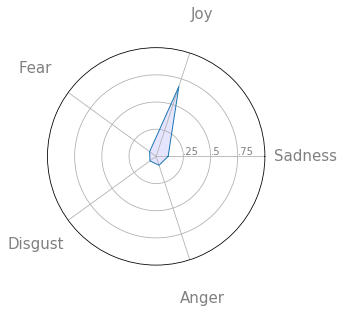

In [26]:
# Set data
cols1 = ['Questions','Sadness','Joy','Fear','Disgust','Anger']
dfp = pd.DataFrame({
'Questions': ['Q1'],
'Sadness': [mean_sad],
'Joy': [mean_joy],
'Fear': [mean_fear],
'Disgust': [mean_disg],
'Anger': [mean_ang]
},columns=cols1)

# number of variable
categories=list(dfp)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=dfp.loc[0].drop('Questions').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=15)
ax.tick_params(axis='x',pad=30)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([.25,.5,.75], [".25",".5",".75"], color="grey", size=10)
plt.ylim(0,1)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

plt.show()


In [28]:
#sort by an emotional value and print in ascending order
dfs = df.sort_values(by=['q1_anger'],ascending=False)
for i in dfs['q1_text']:
    print(i)
print(dfs['q1_anger'])

They're okay. I feel like I need to build a personal connection otherwise they're slobbery and annoying. 
nan
nan
They are great and amazing and precious, except for small dogs. While big dogs are loveable and playful, small dogs are useless and annoying.
they're ok, but sometimes they can be annoying, but most times they're cute. I believe what I wrote base on personal experiences
nan
nan
Don't like them and try to get away from them. Got attacked by a farm dog once and that is why I believe that I do not like being around them. 
They must be exterminated. They are secretly plotting to overthrow all of our major world governments.
nan
nan
I hate small dogs, but medium sized to big dogs are the best!  They're cute and cheer people up.    
I don't like them, they're filthy, loud and obnoxious. They also smell disgusting and can cause a mess at home
nan
I feel that dogs are superior to humans because they are more open-minded, loving, and less dramatic and concerned with trivialities. 
n